In [37]:
!pip uninstall  tensorflow-addons keras tensorflow-addons -y
!pip install tensorflow-addons
!pip install "keras<3.0.0" "tensorflow<2.16" "tf-models-official<2.16" mediapipe-model-maker

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Successfully uninstalled tensorflow-addons-0.23.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
  Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [38]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow.keras as keras 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import defaultdict
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
from keras.callbacks import ModelCheckpoint
import cv2
from tensorflow.keras.optimizers import AdamW
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
data_dir = '/kaggle/input/9fanta-coca-yen-update-colgate/data-process'
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/d/nguynngchuy2222/datatest/test",
    target_size=(64, 64),
    batch_size=64,
    class_mode='sparse',
    shuffle=False
)
print(train_generator.class_indices)
print(test_generator.class_indices)


Found 8223 images belonging to 9 classes.
Found 2049 images belonging to 9 classes.
{'Blue Lays': 0, 'Coca': 1, 'Colagate': 2, 'Fanta': 3, 'Laybuoy': 4, 'Red Lays': 5, 'Safeguard': 6, 'Sunsil': 7, 'Yen': 8}
Found 868 images belonging to 9 classes.
{'Blue Lays': 0, 'Coca': 1, 'Colagate': 2, 'Fanta': 3, 'Laybuoy': 4, 'Red Lays': 5, 'Safeguard': 6, 'Sunsil': 7, 'Yen': 8}


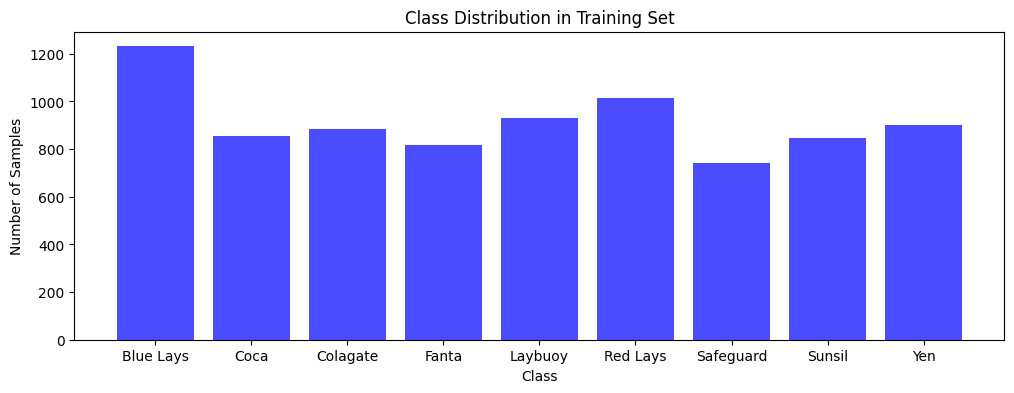

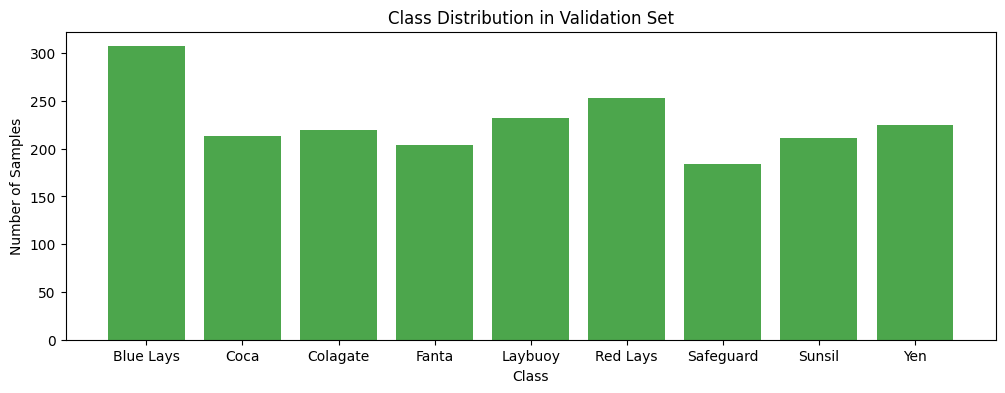

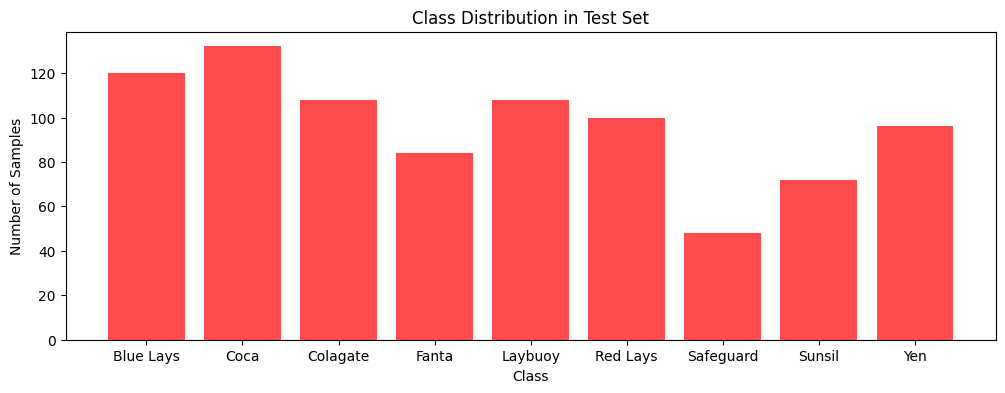

In [40]:
train_labels = train_generator.classes
val_labels = validation_generator.classes
test_labels = test_generator.classes

class_names = list(train_generator.class_indices.keys())

train_class_counts = np.bincount(train_labels)
val_class_counts = np.bincount(val_labels)
test_class_counts = np.bincount(test_labels)

plt.figure(figsize=(12, 4))
plt.bar(class_names, train_class_counts, color='blue', alpha=0.7)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(class_names, val_class_counts, color='green', alpha=0.7)
plt.title("Class Distribution in Validation Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(class_names, test_class_counts, color='red', alpha=0.7)
plt.title("Class Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


In [41]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
    )

class MLP(layers.Layer):
    def __init__(self, hidden_units, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.dense_layers = [layers.Dense(units, activation=tf.nn.relu) for units in hidden_units]
        self.dropout_layers = [layers.Dropout(dropout_rate) for _ in hidden_units]

    def call(self, x, training=False):
        for dense, dropout in zip(self.dense_layers, self.dropout_layers):
            x = dense(x)
            x = dropout(x, training=training)
        return x

class TransformerEncoderLayer(layers.Layer):
    def __init__(self, num_heads, mlp_dim, dropout, transformer_units):
        super(TransformerEncoderLayer, self).__init__()
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        self.mlp = MLP(hidden_units=transformer_units, dropout_rate=self.dropout)

    def build(self, input_shape):
        _, num_patches, embed_dim = input_shape
        self.attention = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=embed_dim)
        
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate=self.dropout)
        self.dropout2 = layers.Dropout(rate=self.dropout)

    def call(self, inputs, training=False):
        norm = self.layer_norm1(inputs)
        attention_output = self.attention(norm, norm)
        attention_output = self.dropout1(attention_output, training=training)
        attention_output = self.layer_norm2(inputs + attention_output)
        mlp_output = self.mlp(attention_output)
        mlp_output = self.dropout2(mlp_output, training=training)
        mlp_output = attention_output + mlp_output
        return mlp_output

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]
        channels = tf.shape(images)[3]

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )

        num_patches_height = height // self.patch_size
        num_patches_width = width // self.patch_size
        num_patches = num_patches_height * num_patches_width

        patch_dims = tf.shape(patches)[-1]
        patches = tf.reshape(patches, (batch_size, num_patches, patch_dims))

        return patches
    
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()

        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
            )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = patch + self.position_embedding(positions)
        return encoded
    

    
def VisionTransformer(num_classes, num_layers, num_heads, mlp_dim, patch_size, input_shape=(64,64, 3), dropout=0.4):
    inputs = Input(shape=input_shape)
    H, W, C = input_shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    num_patches = num_patches_h * num_patches_w
    output_dim = patch_size ** 2 * C
    transformer_units = [
            output_dim * 2,
            output_dim,
        ] 
    inputs = data_augmentation(inputs)
    # L1 : Create patches
    patches = Patches(patch_size)(inputs)
    # L2 + L7: Encode patches
    encoded_patches = PatchEncoder(num_patches, output_dim)(patches)
    # L3 : Transformer Encoder block
    for _ in range(num_layers):
        encoder = TransformerEncoderLayer(num_heads=num_heads, mlp_dim=mlp_dim, dropout=dropout, transformer_units = transformer_units)
        encoded_patches = encoder(encoded_patches)
        
    # L4 : Create a [batch_size, projection_dim] tensor
    x = tf.reduce_mean(encoded_patches, axis=1)
    # L5 : Add MLP Head
    features = MLP(hidden_units=[1024,512], dropout_rate=dropout)(x)
    # L6 : Classify outputs
    outputs = layers.Dense(units=num_classes, activation='softmax')(features)
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [42]:
num_classes =9
num_layers = 6
num_heads = 10
mlp_dim = 512
patch_size= 4
# try:
#     loaded_model = load_model("vit_model.h5")
#     vit_model = loaded_model
#     print("Model loaded successfully.")
# except Exception as e:
vit_model = VisionTransformer(num_classes=num_classes,
                              num_layers=num_layers,
                              num_heads=num_heads,
                              mlp_dim=mlp_dim,
                              patch_size = patch_size)

vit_model.compile(optimizer=AdamW(learning_rate=1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

# Print the summary
vit_model(tf.zeros([1,64,64,3]))
vit_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 patches_4 (Patches)         (None, 256, 48)           0         
                                                                 
 patch_encoder_4 (PatchEnco  (None, 256, 48)           12288     
 der)                                                            
                                                                 
 transformer_encoder_layer_  (None, 256, 48)           103200    
 24 (TransformerEncoderLaye                                      
 r)                                                              
                                                                 
 transformer_encoder_layer_  (None, 256, 48)           103200    
 25 (TransformerEncoderLaye                                

In [43]:

filepath="checkpoint.weights.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max',
                             save_freq='epoch')

early_stop = keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=2)

callbacks_list = [checkpoint, early_stop]

history = vit_model.fit(
    train_generator,
    epochs=100,
    batch_size=64,
    callbacks=callbacks_list,
    validation_data=validation_generator,
)

Epoch 1/100
129/129 [==============================] - 60s 330ms/step - loss: 1.5847 - accuracy: 0.4098 - val_loss: 1.2533 - val_accuracy: 0.5598
Epoch 2/100
129/129 [==============================] - 38s 291ms/step - loss: 1.0422 - accuracy: 0.6068 - val_loss: 0.8898 - val_accuracy: 0.6759
Epoch 3/100
129/129 [==============================] - 37s 286ms/step - loss: 0.6642 - accuracy: 0.7524 - val_loss: 0.7463 - val_accuracy: 0.7155
Epoch 4/100
129/129 [==============================] - 38s 292ms/step - loss: 0.5415 - accuracy: 0.7956 - val_loss: 0.6222 - val_accuracy: 0.7623
Epoch 5/100
129/129 [==============================] - 38s 292ms/step - loss: 0.4267 - accuracy: 0.8350 - val_loss: 0.4777 - val_accuracy: 0.8111
Epoch 6/100
129/129 [==============================] - 39s 303ms/step - loss: 0.3531 - accuracy: 0.8633 - val_loss: 0.5679 - val_accuracy: 0.7862
Epoch 7/100
129/129 [==============================] - 38s 292ms/step - loss: 0.2940 - accuracy: 0.8861 - val_loss: 0.4332 -

In [44]:
for x_batch, y_batch in train_generator:
    print("Shape of y_batch:", tf.shape(y_batch))
    break

Shape of y_batch: tf.Tensor([64], shape=(1,), dtype=int32)


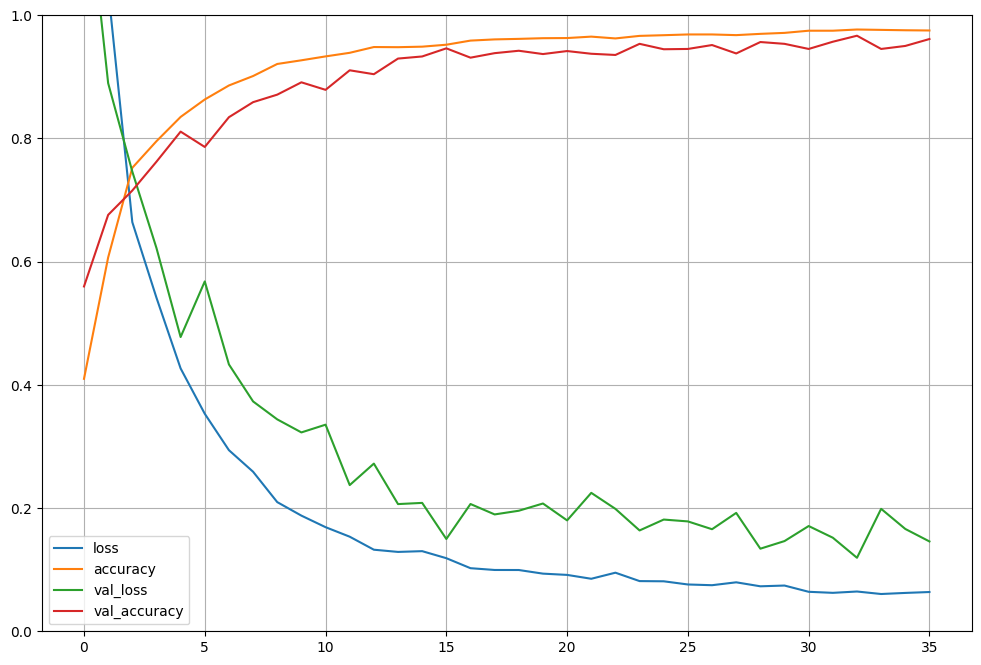

In [45]:
# plot the learning curves
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

In [46]:
vit_model.save("vit_v4_8_label_013_095_018_093")
import shutil
# Đường dẫn đến thư mục cần nén
folder_path = '/kaggle/working/vit_v4_8_label_013_095_018_093'
# Đường dẫn và tên tệp ZIP đầu ra
zip_file_path = '/kaggle/working/vit_v4_8_label_013_095_018_093.zip'
# Nén thư mục thành tệp ZIP
shutil.make_archive('/kaggle/working/vit_v4_8_label_013_095_018_093', 'zip', folder_path)

'/kaggle/working/vit_v4_8_label_013_095_018_093.zip'

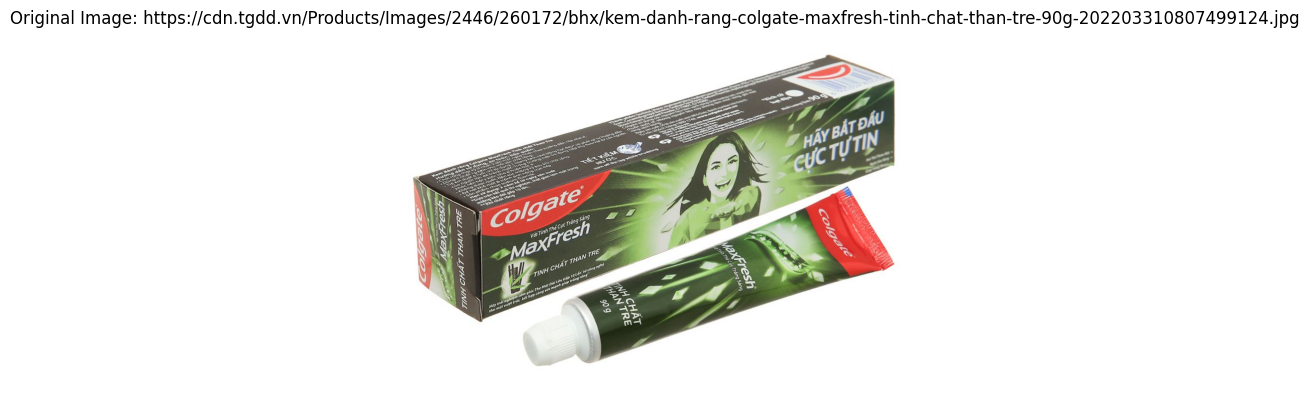

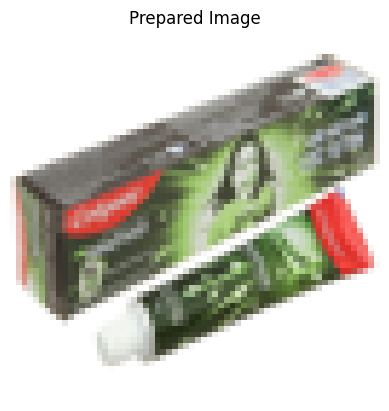

1/1 [==============================] - 1s 856ms/step
[[2.5027284e-11 3.3570424e-10 9.9979609e-01 9.1994639e-07 1.5358131e-08
  5.8608143e-06 2.3490860e-05 9.3183939e-05 8.0410675e-05]]
(1, 9)
Kết quả dự đoán: 2, Xác suất: 0.9997960925102234


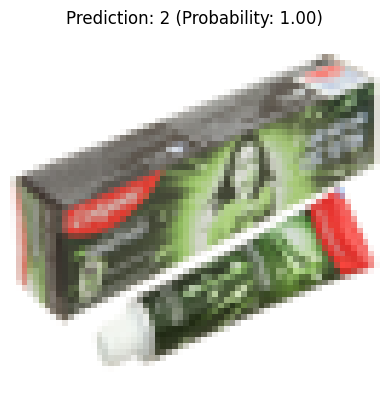

In [47]:
import requests
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from io import BytesIO

# Hàm để tải và chuẩn bị hình ảnh từ URL
def load_and_prepare_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')  # Chuyển đổi ảnh sang RGB để đảm bảo có 3 kênh màu
    img = img.resize((64, 64))  # Sử dụng kích thước phù hợp với mô hình đã huấn luyện
    img = np.array(img).astype('float32') / 255.0  # Chuẩn hóa ảnh
    img = np.expand_dims(img, axis=0)  # Thêm chiều batch size
    return img

# Hàm để kiểm tra hình ảnh sau khi tải và chuẩn bị
def check_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.title(f'Original Image: {url}')
    plt.axis('off')
    plt.show()

# URL của hình ảnh
url = 'https://cdn.tgdd.vn/Products/Images/2446/260172/bhx/kem-danh-rang-colgate-maxfresh-tinh-chat-than-tre-90g-202203310807499124.jpg'

# Kiểm tra hình ảnh gốc
check_image_from_url(url)

# Tải và chuẩn bị hình ảnh
x_test2 = load_and_prepare_image_from_url(url)

# Kiểm tra xem hình ảnh đã được chuẩn bị đúng chưa
if x_test2 is None or x_test2.shape != (1, 64, 64, 3):
    print("Có lỗi khi chuẩn bị hình ảnh đầu vào.")
else:
    # Hiển thị hình ảnh đã chuẩn bị để kiểm tra
    plt.imshow(x_test2[0])
    plt.title('Prepared Image')
    plt.axis('off')
    plt.show()
    
    # Bước 3: Dự đoán với mô hình ViT
    try:
        y_pred2 = vit_model.predict(x_test2)
        print(y_pred2)
        # Lấy chỉ số của giá trị lớn nhất (lớp được dự đoán)
        y_pred2_max_index = np.argmax(y_pred2, axis=1)[0]
        y_pred2_max_value = np.max(y_pred2)
        print(y_pred2.shape)
        # Hiển thị kết quả dự đoán
        print(f'Kết quả dự đoán: {y_pred2_max_index}, Xác suất: {y_pred2_max_value}')
        
        # Hiển thị hình ảnh với kết quả dự đoán
        plt.imshow(x_test2[0])
        plt.title(f'Prediction: {y_pred2_max_index} (Probability: {y_pred2_max_value:.2f})')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Có lỗi xảy ra khi dự đoán: {e}")

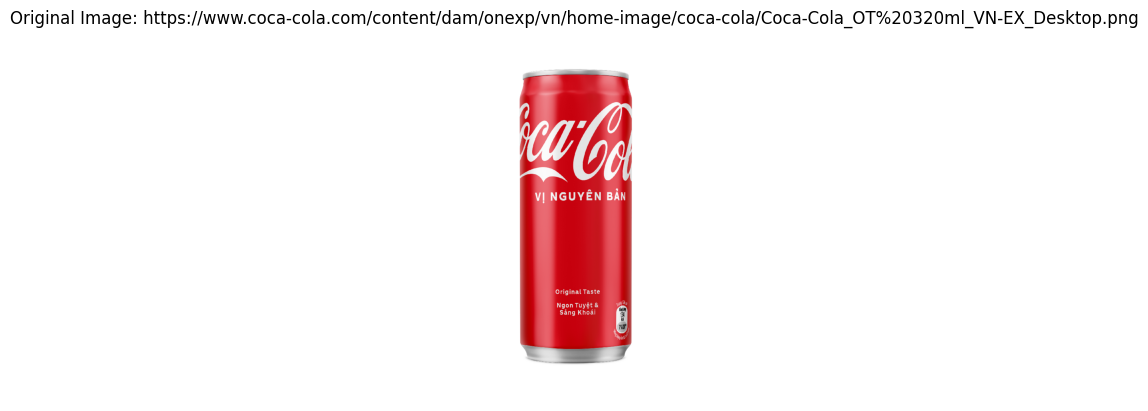

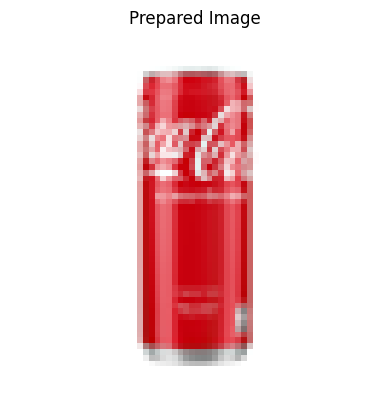

1/1 [==============================] - 0s 27ms/step
[[5.8981254e-13 9.9999821e-01 2.5168695e-11 1.4461571e-06 3.9388323e-07
  1.7094834e-09 1.2414166e-08 7.4746711e-12 1.1351897e-13]]
(1, 9)
Kết quả dự đoán: 1, Xác suất: 0.9999982118606567


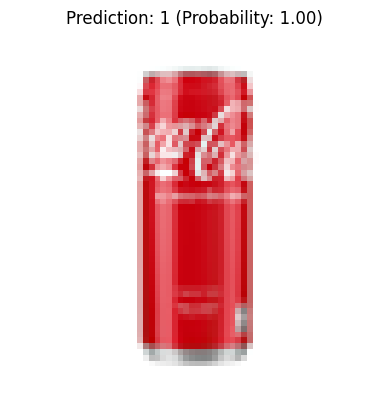

In [48]:
import requests
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from io import BytesIO

# Hàm để tải và chuẩn bị hình ảnh từ URL
def load_and_prepare_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')  # Chuyển đổi ảnh sang RGB để đảm bảo có 3 kênh màu
    img = img.resize((64, 64))  # Sử dụng kích thước phù hợp với mô hình đã huấn luyện
    img = np.array(img).astype('float32') / 255.0  # Chuẩn hóa ảnh
    img = np.expand_dims(img, axis=0)  # Thêm chiều batch size
    return img

# Hàm để kiểm tra hình ảnh sau khi tải và chuẩn bị
def check_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.title(f'Original Image: {url}')
    plt.axis('off')
    plt.show()

# URL của hình ảnh
url = 'https://www.coca-cola.com/content/dam/onexp/vn/home-image/coca-cola/Coca-Cola_OT%20320ml_VN-EX_Desktop.png'

# Kiểm tra hình ảnh gốc
check_image_from_url(url)

# Tải và chuẩn bị hình ảnh
x_test2 = load_and_prepare_image_from_url(url)

# Kiểm tra xem hình ảnh đã được chuẩn bị đúng chưa
if x_test2 is None or x_test2.shape != (1, 64, 64, 3):
    print("Có lỗi khi chuẩn bị hình ảnh đầu vào.")
else:
    # Hiển thị hình ảnh đã chuẩn bị để kiểm tra
    plt.imshow(x_test2[0])
    plt.title('Prepared Image')
    plt.axis('off')
    plt.show()
    
    # Bước 3: Dự đoán với mô hình ViT
    try:
        y_pred2 = vit_model.predict(x_test2)
        print(y_pred2)
        # Lấy chỉ số của giá trị lớn nhất (lớp được dự đoán)
        y_pred2_max_index = np.argmax(y_pred2, axis=1)[0]
        y_pred2_max_value = np.max(y_pred2)
        print(y_pred2.shape)
        # Hiển thị kết quả dự đoán
        print(f'Kết quả dự đoán: {y_pred2_max_index}, Xác suất: {y_pred2_max_value}')
        
        # Hiển thị hình ảnh với kết quả dự đoán
        plt.imshow(x_test2[0])
        plt.title(f'Prediction: {y_pred2_max_index} (Probability: {y_pred2_max_value:.2f})')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Có lỗi xảy ra khi dự đoán: {e}")

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

predictions = vit_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))



14/14 [==============================] - 2s 154ms/step
Classification Report:
              precision    recall  f1-score   support

   Blue Lays       1.00      0.87      0.93       120
        Coca       0.71      1.00      0.83       132
    Colagate       0.97      0.96      0.97       108
       Fanta       0.93      1.00      0.97        84
     Laybuoy       0.94      0.46      0.62       108
    Red Lays       0.93      0.99      0.96       100
   Safeguard       0.79      0.88      0.83        48
      Sunsil       0.92      0.93      0.92        72
         Yen       1.00      1.00      1.00        96

    accuracy                           0.90       868
   macro avg       0.91      0.90      0.89       868
weighted avg       0.91      0.90      0.89       868

